# Exercise 05 Image Segmentation

In this notebook, we will train a 2D U-net for nuclei segmentation in the Kaggle Nuclei dataset.

Written by Valentyna Zinchenko, Constantin Pape and William Patton.

## 1) The libraries

In [1]:
%matplotlib inline
%load_ext tensorboard
import os
from pathlib import Path
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

## 2) Data loading and preprocessing

### Data download and exploration
For this exercise we will be using the Kaggle 2018 Data Science Bowl data. We will try to segment it with the state of the art network.
Let's start with loading the data.

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1L344AoTTx-mu9MyNt-2iZ5A3ww3tC_Zp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1L344AoTTx-mu9MyNt-2iZ5A3ww3tC_Zp" -O kaggle_data.zip && rm -rf /tmp/cookies.txt
!unzip -u -qq kaggle_data.zip && rm kaggle_data.zip

--2022-07-01 20:20:59--  https://docs.google.com/uc?export=download&confirm=t&id=1L344AoTTx-mu9MyNt-2iZ5A3ww3tC_Zp
Resolving docs.google.com (docs.google.com)... 2607:f8b0:400a:803::200e, 142.250.217.78
Connecting to docs.google.com (docs.google.com)|2607:f8b0:400a:803::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5iofgsujs3sas05ctviv5iqtt1tgfb7j/1656732000000/17999766797462482814/*/1L344AoTTx-mu9MyNt-2iZ5A3ww3tC_Zp?e=download&uuid=c71b2f56-80c3-4862-bb5a-75dd74f05320 [following]
--2022-07-01 20:20:59--  https://doc-04-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5iofgsujs3sas05ctviv5iqtt1tgfb7j/1656732000000/17999766797462482814/*/1L344AoTTx-mu9MyNt-2iZ5A3ww3tC_Zp?e=download&uuid=c71b2f56-80c3-4862-bb5a-75dd74f05320
Resolving doc-04-18-docs.googleusercontent.com (doc-04-18-docs.googleusercontent.com)... 2607:f8b0:400a:80

Now make sure that the data was successfully extracted: if everything went fine, you should have folders `nuclei_train_data` and `nuclei_val_data` in your working directory. Check if it is the case:

In [2]:
!ls -ltrh

total 288K
drwxr-xr-x 136 skar skar  20K Dec 13  2019 nuclei_val_data
drwxr-xr-x 538 skar skar  60K Dec 13  2019 nuclei_train_data
-rw-rw-r--   1 skar skar  417 Jul  1 19:16 README.md
drwxrwxr-x   3 skar skar 4.0K Jul  1 20:23 runs
-rw-rw-r--   1 skar skar 191K Jul  6 05:29 unet_pytorch.ipynb


__Task 2.1__: Use `ls` to explore the contents of both folders. Running `ls your_folder_name` should display you what is stored in the folder of your interest.

 How are the images stored? What format do they have?

In [3]:
!ls -l nuclei_train_data/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
!ls nuclei_train_data | wc -l

total 520
-rw-rw-r-- 1 skar skar 262298 Sep 27  2021 image.tif
-rw-rw-r-- 1 skar skar 262278 Sep 27  2021 mask.tif
536


__Task 2.2__: Visualize some of the files.

Hint: you can use the following function to display an image:

In [4]:
def show_one_image(image_path):
    image = imageio.imread(image_path)
    plt.imshow(image)

/tmp/ipykernel_9001/2626062983.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


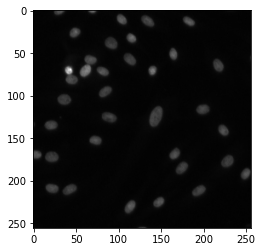

In [5]:
show_one_image(
    Path(
        "nuclei_train_data/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/mask.tif"
    )
)
show_one_image(
    Path(
        "nuclei_train_data/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/image.tif"
    )
)


### Data processing
Making the data accessible for training. What one would normally start with in any machine learning pipeline is writing a dataset - a class that will fetch the training samples. Once you switch to using your own data, you would have to figure out how to fetch the data yourself. Luckily most of the functionality is already provided by PyTorch, but what you need to do is to write a class, that will actually supply the dataloader with training samples - a Dataset.

Torch Dataset docs can be found [here](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) and a totorial on how to use them can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class).

The main idea: any Dataset class should implement two "magic" methods:
1) `__len__(self)`: this defines the behavior of the python builtin `len` function. i.e:
    - `len(dataset)` => number of elements in your dataset
2) `__getitem__(self, idx)`: this defines bracket indexing behavior of your class. i.e:
    - `dataset[idx]` => element of your dataset associated with `idx`

For this exercise you will not have to do it yourself yet, but please carefully read through the provided class:

In [6]:
# any PyTorch dataset class should inherit the initial torch.utils.data.Dataset
class NucleiDataset(Dataset):
    """A PyTorch dataset to load cell images and nuclei masks"""

    def __init__(self, root_dir, transform=None, img_transform=None):
        self.root_dir = root_dir  # the directory with all the training samples
        self.samples = os.listdir(root_dir)  # list the samples
        self.transform = (
            transform  # transformations to apply to both inputs and targets
        )
        self.img_transform = img_transform  # transformations to apply to raw image only
        #  transformations to apply just to inputs
        self.inp_transforms = transforms.Compose(
            [
                transforms.Grayscale(),  # some of the images are RGB
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        # transformations to apply just to targets
        self.mask_transforms = transforms.ToTensor()

    # get the total number of samples
    def __len__(self):
        return len(self.samples)

    # fetch the training sample given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.samples[idx], "image.tif")
        # we'll be using Pillow library for reading files
        # since many torchvision transforms operate on PIL images
        image = Image.open(img_path)
        image = self.inp_transforms(image)
        mask_path = os.path.join(self.root_dir, self.samples[idx], "mask.tif")
        mask = Image.open(mask_path)
        mask = self.mask_transforms(mask)
        if self.transform is not None:
            image, mask = self.transform([image, mask])
        if self.img_transform is not None:
            image = self.img_transform([image])
        return image, mask


__Task 2.3__: Use the defined dataset to show a random image/mask pair

Hint: use the `len` function and `[]` indexing defined by `__len__` and `__get_index__` in the Dataset class to fill in the function below 

In [7]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))  # take a random sample
    img, mask = dataset[idx]  # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)  # make two plots on one figure
    axarr[0].imshow(img[0])  # show the image
    axarr[1].imshow(mask[0])  # show the masks
    _ = [ax.axis("off") for ax in axarr]  # remove the axes
    print("Image size is %s" % {img[0].shape})
    plt.show()


Image size is {torch.Size([360, 360])}


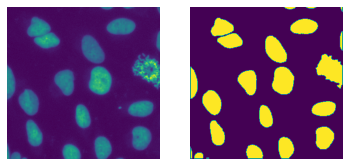

In [8]:
TRAIN_DATA_PATH = "nuclei_train_data"
train_data = NucleiDataset(TRAIN_DATA_PATH)

show_random_dataset_image(train_data)



As you can probably see, if you clicked enough times, some of the images are really huge! What happens if we load them into memory and run the model on them? We might run out of memory. That's why normally, when training networks on images or volumes one has to be really careful about the sizes. In practice, you would want to regulate their size. Additional reason for restraining the size is: if we want to train in batches (faster and more stable training), we need all the images in the batch to be of the same size. That is why we prefer to either resize or crop them.

Here is a function (well, actually a class), that will apply a transformation 'random crop'. Notice that we apply it to images and masks simultaneously to make sure they correspond, despite the randomness.

In case anybody is wondering why we have to bother to write a whole class for it instead of simply coping the images directly in the dataset: we want to keep the code modular. We want to write one dataset object, and then we can try all the possible transforms with this one dataset. Similarly, we want to write one Randomcrop transform object, and then we can reuse it for any other image datasets we night have in the future.


In [9]:
class RandomCrop(object):
    """Crop randomly the input image and the output mask"""

    def __init__(self, crop_size):
        # check if the crop size is of a valid type
        assert isinstance(crop_size, (int, tuple, list))
        if isinstance(crop_size, int):
            # if the crop size is an integer, we use the same for both dimensions
            self.output_size = (crop_size, crop_size)
        else:
            assert len(crop_size) == 2
            self.crop_size = crop_size

    # this function makes our class callable
    def __call__(self, sample):
        # we need to crop both input and mask at the same time
        assert len(sample) == 2
        image, mask = sample
        # the first dimension is channels, then width, then height
        w, h = image.shape[1:]
        new_w, new_h = self.output_size
        # choose a random place to crop
        top = np.random.randint(0, h - new_h) if h - new_h > 0 else 0
        left = np.random.randint(0, w - new_w) if w - new_w > 0 else 0
        # crop and return
        image = image[:, left : left + new_w, top : top + new_h]
        mask = mask[:, left : left + new_w, top : top + new_h]
        return image, mask


PS: PyTorch already has quite a bunch of all possible data transforms, so if you need one, check [here](https://pytorch.org/docs/stable/torchvision/transforms.html). The biggest problem with them is that they are clearly separated into transforms applied to PIL images (remember, we initially load the images as PIL.Image?) and torch.tensors (remember, we converted the images into tensors by calling transforms.ToTensor()?). This can be incredibly annoying if for some reason you might need to transorm your images to tensors before applying any other transforms or you don't want to use PIL library at all.

In [10]:
train_data = NucleiDataset(TRAIN_DATA_PATH, RandomCrop(256))
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)


Image size is {torch.Size([256, 256])}


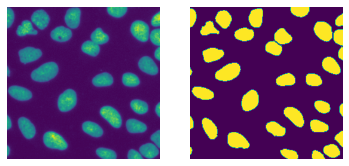

In [11]:
show_random_dataset_image(train_data)


And the same for the validation data:

In [12]:
VAL_DATA_PATH = "nuclei_val_data"
val_data = NucleiDataset(VAL_DATA_PATH, RandomCrop(256))
val_loader = DataLoader(val_data, batch_size=5)


Image size is {torch.Size([256, 256])}


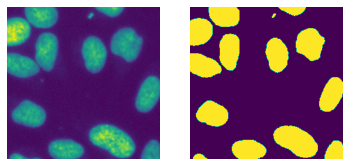

In [13]:
show_random_dataset_image(val_data)


## Checkpoint 1

We will go over the steps up to this point soon. If you have time to spare, consider experimenting with various augmentations. Your goal is to augment your training data in such a way that you expand the distribution of training data to cover the distribution of the rest of your data and avoid overly relying on extrapolation at test time. If this sounds somewhat vague thats because augmenting is a bit of an artform. Common augmentations that have been shown to work well are adding noise, mirror, transpose, and rotations.

## 3) The model: U-net

Now we need to define the architecture of the model to use. We will use a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) that has proven to steadily outperform the other architectures in segmenting biological and medical images.

The image of the model precisely describes all the building blocks you need to use to create it. All of them can be found in the list of PyTorch layers (modules) [here](https://pytorch.org/docs/stable/nn.html#convolution-layers).

The U-net has an encoder-decoder structure:

In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via transposed convolutions.

In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

In [1]:
class UNet(nn.Module):
    """UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """

    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements

    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with relu activation
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def __init__(self, in_channels=1, out_channels=1, depth=4, final_activation=None):
        super().__init__()

        assert depth < 7, "Max supported depth is 7"

        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 4
        self.depth = depth

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(
                final_activation, nn.Module
            ), "Activation must be torch module"

        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList

        # modules of the encoder path
        self.encoder = nn.ModuleList(
            [
                self._conv_block(in_channels, 16),
                self._conv_block(16, 32),
                self._conv_block(32, 64),
                self._conv_block(64, 128),
                self._conv_block(128, 256),
                self._conv_block(256, 512),
                self._conv_block(512, 1024),
            ][:depth]
        )
        # the base convolution block
        if depth >= 1:
            self.base = self._conv_block(2 ** (depth + 3), 2 ** (depth + 4))
        else:
            self.base = self._conv_block(1, 2 ** (depth + 4))
        # modules of the decoder path
        self.decoder = nn.ModuleList(
            [
                self._conv_block(2048, 1024),
                self._conv_block(1024, 512),
                self._conv_block(512, 256),
                self._conv_block(256, 128),
                self._conv_block(128, 64),
                self._conv_block(64, 32),
                self._conv_block(32, 16),
            ][-depth:]
        )

        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList(
            [
                self._upsampler(2048, 1024),
                self._upsampler(1024, 512),
                self._upsampler(512, 256),
                self._upsampler(256, 128),
                self._upsampler(128, 64),
                self._upsampler(64, 32),
                self._upsampler(32, 16),
            ][-depth:]
        )
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(16, out_channels, 1)
        self.activation = final_activation

    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)

        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))

        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x


NameError: name 'nn' is not defined

__Task 3.1__: Spot the best UNet

In the next cell you fill find a series of UNet definitions. Most of them won't work. Some of them will work but not well. One will do well. Can you identify which model is the winner? Unfortunately you can't yet test your hypotheses yet since we have not covered loss functions, optimizers, and train/validation loops.

In [20]:
unetA = UNet(
    in_channels=1, out_channels=1, depth=4, final_activation=torch.nn.Sigmoid()
)
unetB = UNet(in_channels=1, out_channels=1, depth=7, final_activation=None)
unetC = torch.nn.Sequential(
    UNet(in_channels=1, out_channels=1, depth=4, final_activation=torch.nn.ReLU()),
    torch.nn.Sigmoid(),
)
unetD = torch.nn.Sequential(
    UNet(in_channels=1, out_channels=1, depth=1, final_activation=None),
    torch.nn.Sigmoid(),
)


In [21]:
# unetA: The correct unet.
# unetB: too deep. I expect memory issues trying to fit data through this model, also may not have large enough pictures to use the extra context
# unetC: A classic mistake putting a Sigmoid after a Relu activation. You will never predict anything < 0.5
# unetD: barely any depth to this unet. It should train and give you what you want, I just wouldn't expect good performance
best_unet = unetA

## 4) Loss and distance metrics

The next step to do would be writing a loss function - a metric that will tell us how close we are to the desired output. This metric should be differentiable, since this is the value to be backpropagated. The are [multiple losses](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html) we could use for the segmentation task.

Take a moment to think which one is better to use. If you are not sure, don't forget that you can always google! Before you start implementing the loss yourself, take a look at the [losses](https://pytorch.org/docs/stable/nn.html#loss-functions) already implemented in PyTorch. You can also look for implementations on GitHub.


__Task 4.1__: implement your loss (or take one from pytorch):

In [36]:
# implement your loss here or initialize the one of your choice from pytorch
loss_function = nn.BCELoss()

# loss function sanity check:
target = torch.tensor([0.0, 1.0])
good_prediction = torch.tensor([0.01, 0.99])
bad_prediction = torch.tensor([0.4, 0.6])
wrong_prediction = torch.tensor([0.9, 0.1])

# Can your loss function handle predictions outside of (0, 1)?
# Some loss functions will be perfectly happy with this which may
# make them easier to work with, but predictions outside the expected
# range will not work well with our soon to be discussed evaluation metric.
out_of_bounds_prediction = torch.tensor([-0.1, 1.1])

good_loss = loss_function(good_prediction, target)
bad_loss = loss_function(bad_prediction, target)
wrong_loss = loss_function(wrong_prediction, target)

assert good_loss < bad_loss
assert bad_loss < wrong_loss


We will use the [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels. It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.
The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [57]:
# sorensen dice coefficient implemented in torch
# the coefficient takes values in [0, 1], where 0 is
# the worst score, 1 is the best score
class DiceCoefficient(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    # the dice coefficient of two sets represented as vectors a, b ca be
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        return 2 * intersection / denominator.clamp(min=self.eps)


## 5) Training

Let's start with writing training and validation functions.

__Task 5.1__: fix in all the TODOs to make the train function work. If confused, you can use this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) as a template 

In [47]:
# apply training for one epoch
def train(
    model,
    loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=100,
    log_image_interval=20,
    tb_logger=None,
    device=None,
    early_stop=False,
):
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

    # set the model to train mode
    model.train()

    # move model to device
    model = model.to(device)

    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)

        # zero the gradients for this iteration
        optimizer.zero_grad()

        # apply model and calculate loss
        prediction = model(x)
        loss = loss_function(prediction, y)

        # backpropagate the loss and adjust the parameters
        loss.backward()
        optimizer.step()

        # log to console
        if batch_id % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_id * len(x),
                    len(loader.dataset),
                    100.0 * batch_id / len(loader),
                    loss.item(),
                )
            )

        # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(
                tag="train_loss", scalar_value=loss.item(), global_step=step
            )
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                tb_logger.add_images(
                    tag="input", img_tensor=x.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="target", img_tensor=y.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="prediction",
                    img_tensor=prediction.to("cpu").detach(),
                    global_step=step,
                )

        if early_stop and batch_id > 5:
            print("Stopping test early!")
            break


# Quick sanity check for your train function to make sure no errors are thrown:
# Good place to test unetA, unetB, unetC, unetD to see if you can eliminate some
test_net = UNet(1, 1, depth=1, final_activation=nn.Sigmoid())

train(
    test_net,
    train_loader,
    optimizer=torch.optim.Adam(test_net.parameters()),
    loss_function=torch.nn.MSELoss,
    epoch=0,
    log_interval=1,
    early_stop=True,
)


Train Epoch: 0 [0/536 (0%)]	Loss: 0.792422
Train Epoch: 0 [5/536 (1%)]	Loss: 0.794725
Train Epoch: 0 [10/536 (2%)]	Loss: 0.784159
Train Epoch: 0 [15/536 (3%)]	Loss: 0.784280
Train Epoch: 0 [20/536 (4%)]	Loss: 0.767693
Train Epoch: 0 [25/536 (5%)]	Loss: 0.765531
Train Epoch: 0 [30/536 (6%)]	Loss: 0.761864
Stopping test early!


__Task 5.2__: fix in all the TODOs to make the validate function work. If confused, you can use this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) as a template

In [58]:
# run validation after training epoch
def validate(
    model,
    loader,
    loss_function,
    metric,
    step=None,
    tb_logger=None,
    device=None,
):
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

    # set model to eval mode
    model.eval()
    model.to(device)
    
    # running loss and metric values
    val_loss = 0
    val_metric = 0

    # disable gradients during validation
    with torch.no_grad():

        # iterate over validation loader and update loss and metric values
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            prediction = model(x)
            val_loss += loss_function(prediction, y).item()
            val_metric += metric(prediction, y).item()

    # normalize loss and metric
    val_loss /= len(loader)
    val_metric /= len(loader)

    if tb_logger is not None:
        assert (
            step is not None
        ), "Need to know the current step to log validation results"
        tb_logger.add_scalar(tag="val_loss", scalar_value=val_loss, global_step=step)
        tb_logger.add_scalar(
            tag="val_metric", scalar_value=val_metric, global_step=step
        )
        # we always log the last validation images
        tb_logger.add_images(tag="val_input", img_tensor=x.to("cpu"), global_step=step)
        tb_logger.add_images(tag="val_target", img_tensor=y.to("cpu"), global_step=step)
        tb_logger.add_images(
            tag="val_prediction", img_tensor=prediction.to("cpu"), global_step=step
        )

    print(
        "\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n".format(
            val_loss, val_metric
        )
    )


# Quick sanity check for your train function to make sure no errors are thrown:
test_net = UNet(1, 1, depth=1, final_activation=None)

# build the dice coefficient metric

validate(
    test_net,
    train_loader,
    loss_function=torch.nn.MSELoss(),
    metric=DiceCoefficient(),
    step=0
)


Validate: Average loss: 0.0502, Average Metric: 0.7181




We want to use GPU to train faster. Make sure GPU is available

In [53]:
assert torch.cuda.is_available()

AssertionError: 

In [54]:
# start a tensorboard writer
logger = SummaryWriter('runs/Unet')
%tensorboard --logdir runs

In [56]:
# Use the unet you expect to work the best!
net = best_unet

# use adam optimizer
optimizer = torch.optim.Adam(net.parameters())

# build the dice coefficient metric
metric = DiceCoefficient()

# train for 25 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 25
for epoch in range(n_epochs):
    # train
    train(
        net,
        train_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        epoch=epoch,
        log_interval=5,
        tb_logger=logger,
    )
    step = epoch * len(train_loader.dataset)
    # validate
    validate(net, val_loader, loss_function, metric, step=step, tb_logger=logger)


Train Epoch: 0 [0/536 (0%)]	Loss: 0.344474
Train Epoch: 0 [25/536 (5%)]	Loss: 0.159833
Train Epoch: 0 [50/536 (9%)]	Loss: 0.289970
Train Epoch: 0 [75/536 (14%)]	Loss: 0.293773
Train Epoch: 0 [100/536 (19%)]	Loss: 0.342015
Train Epoch: 0 [125/536 (23%)]	Loss: 0.227304
Train Epoch: 0 [150/536 (28%)]	Loss: 0.221970
Train Epoch: 0 [175/536 (32%)]	Loss: 0.361218
Train Epoch: 0 [200/536 (37%)]	Loss: 0.181204
Train Epoch: 0 [225/536 (42%)]	Loss: 0.115279
Train Epoch: 0 [250/536 (46%)]	Loss: 0.161866
Train Epoch: 0 [275/536 (51%)]	Loss: 0.225453
Train Epoch: 0 [300/536 (56%)]	Loss: 0.144571
Train Epoch: 0 [325/536 (60%)]	Loss: 0.332369
Train Epoch: 0 [350/536 (65%)]	Loss: 0.187387
Train Epoch: 0 [375/536 (69%)]	Loss: 0.235065
Train Epoch: 0 [400/536 (74%)]	Loss: 0.085926
Train Epoch: 0 [425/536 (79%)]	Loss: 0.155982
Train Epoch: 0 [450/536 (83%)]	Loss: 0.144627
Train Epoch: 0 [475/536 (88%)]	Loss: 0.328728
Train Epoch: 0 [500/536 (93%)]	Loss: 0.076755
Train Epoch: 0 [525/536 (97%)]	Loss: 0.156

KeyboardInterrupt: 

Your validation metric was probably around 88% by the end of the training. That sounds good enough, but an equally important thing to check is: 
Open the Images tab in your Tensorboard and compare predictions to targets. Do your predictions look reasonable? Are there any obvious failure cases? 
If nothing is clearly wrong, let's see if we can still improve the model performance by changing the model or the loss 

## Additional Exercises 

1. Implement and evaluate the following architecture variants of the U-Net:
    * use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) to normalize convolutional group inputs
    * add one more layer to the Unet model (currently it has 4)

2. Use the Dice coefficient as loss function. Before we only used it for validation, but it is differentiable and can thus also be used as loss. Compare to the results from exercise 2. 
Hint: The optimizer we use finds minima of the loss, but the minimal value for the Dice coefficient corresponds to a bad segmentation. How do we need to change the Dice coefficient to use it as loss nonetheless?

3. Compare the results of these trainings to the first one. If any of the modifications you've implemented show better results, combine them (e.g. add both GroupNorm and one more layer) and run trainings again.
What is the best result you could get?

## Group norm

In [ ]:
class UNetGN(nn.Module):
    """UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """

    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements

    # Convolutional block for single layer of the decoder / encoder
    # we apply two 2d convolutions with relu activation and group norm
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, out_channels),
        )

    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def __init__(self, in_channels=1, out_channels=1, final_activation=None):
        super().__init__()

        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 4
        self.depth = 4

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(
                final_activation, nn.Module
            ), "Activation must be torch module"

        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList

        # modules of the encoder path
        self.encoder = nn.ModuleList(
            [
                self._conv_block(in_channels, 16),
                self._conv_block(16, 32),
                self._conv_block(32, 64),
                self._conv_block(64, 128),
            ]
        )
        # the base convolution block
        self.base = self._conv_block(128, 256)
        # modules of the decoder path
        self.decoder = nn.ModuleList(
            [
                self._conv_block(256, 128),
                self._conv_block(128, 64),
                self._conv_block(64, 32),
                self._conv_block(32, 16),
            ]
        )

        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList(
            [
                self._upsampler(256, 128),
                self._upsampler(128, 64),
                self._upsampler(64, 32),
                self._upsampler(32, 16),
            ]
        )
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(16, out_channels, 1)
        self.activation = final_activation

    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)

        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))

        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x


In [ ]:
net = UNetGN(1, 1, final_activation=nn.Sigmoid())

optimizer = torch.optim.Adam(net.parameters())

metric = DiceCoefficient()

logger = SummaryWriter("runs/UNetGN")


# train for 40 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 40
for epoch in range(n_epochs):
    train(
        net,
        train_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        epoch=epoch,
        log_interval=5,
        tb_logger=logger,
    )
    step = epoch * len(train_loader.dataset)
    validate(net, val_loader, loss_function, metric, step=step, tb_logger=logger)


## More layers

In [ ]:
class UNet5layers(nn.Module):
    """UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """

    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements

    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with relu activation
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def __init__(self, in_channels=1, out_channels=1, final_activation=None):
        super().__init__()

        self.depth = 5

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(
                final_activation, nn.Module
            ), "Activation must be torch module"

        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList

        # modules of the encoder path
        self.encoder = nn.ModuleList(
            [
                self._conv_block(in_channels, 16),
                self._conv_block(16, 32),
                self._conv_block(32, 64),
                self._conv_block(64, 128),
                self._conv_block(128, 256),
            ]
        )
        # the base convolution block
        self.base = self._conv_block(256, 512)
        # modules of the decoder path
        self.decoder = nn.ModuleList(
            [
                self._conv_block(512, 256),
                self._conv_block(256, 128),
                self._conv_block(128, 64),
                self._conv_block(64, 32),
                self._conv_block(32, 16),
            ]
        )

        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList(
            [
                self._upsampler(512, 256),
                self._upsampler(256, 128),
                self._upsampler(128, 64),
                self._upsampler(64, 32),
                self._upsampler(32, 16),
            ]
        )
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(16, out_channels, 1)
        self.activation = final_activation

    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)

        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))

        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x


In [ ]:
net = UNet5layers(1, 1, final_activation=nn.Sigmoid())
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters())

metric = DiceCoefficient()
metric = metric.to(device)

logger = SummaryWriter("runs/UNet5layers")


# train for 25 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 25
for epoch in range(n_epochs):
    train(
        net,
        train_loader,
        optimizer=optimizer,
        loss_function=bce_loss,
        epoch=epoch,
        log_interval=5,
        tb_logger=logger,
    )
    step = epoch * len(train_loader.dataset)
    validate(net, val_loader, bce_loss, metric, step=step, tb_logger=logger)


## Dice loss

In [ ]:
class RevDice(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    # the dice coefficient of two sets represented as vectors a, b ca be
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        return 1 - (2 * intersection / denominator.clamp(min=self.eps))


In [ ]:
dice_loss = RevDice()

net = UNet(1, 1, final_activation=nn.Sigmoid())
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters())

metric = DiceCoefficient()
metric = metric.to(device)

logger = SummaryWriter("runs/UNet_diceloss")


# train for 40 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 40
for epoch in range(n_epochs):
    train(
        net,
        train_loader,
        optimizer=optimizer,
        loss_function=dice_loss,
        epoch=epoch,
        log_interval=5,
        tb_logger=logger,
    )
    step = epoch * len(train_loader.dataset)
    validate(net, val_loader, dice_loss, metric, step=step, tb_logger=logger)


## Group Norm + Dice

In [ ]:
net = UNetGN(1, 1, final_activation=nn.Sigmoid())
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters())

metric = DiceCoefficient()
metric = metric.to(device)

logger = SummaryWriter("runs/UNetGN_diceloss")


# train for 25 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 40
for epoch in range(n_epochs):
    train(
        net,
        train_loader,
        optimizer=optimizer,
        loss_function=dice_loss,
        epoch=epoch,
        log_interval=5,
        tb_logger=logger,
    )
    step = epoch * len(train_loader.dataset)
    validate(net, val_loader, dice_loss, metric, step=step, tb_logger=logger)


## Group Norm + Dice + Unet 5 Layers

In [ ]:
class UNet5layersGN(nn.Module):
    """UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """

    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements

    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with relu activation
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, out_channels),
        )

    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def __init__(self, in_channels=1, out_channels=1, final_activation=None):
        super().__init__()

        self.depth = 5

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(
                final_activation, nn.Module
            ), "Activation must be torch module"

        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList

        # modules of the encoder path
        self.encoder = nn.ModuleList(
            [
                self._conv_block(in_channels, 16),
                self._conv_block(16, 32),
                self._conv_block(32, 64),
                self._conv_block(64, 128),
                self._conv_block(128, 256),
            ]
        )
        # the base convolution block
        self.base = self._conv_block(256, 512)
        # modules of the decoder path
        self.decoder = nn.ModuleList(
            [
                self._conv_block(512, 256),
                self._conv_block(256, 128),
                self._conv_block(128, 64),
                self._conv_block(64, 32),
                self._conv_block(32, 16),
            ]
        )

        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList(
            [
                self._upsampler(512, 256),
                self._upsampler(256, 128),
                self._upsampler(128, 64),
                self._upsampler(64, 32),
                self._upsampler(32, 16),
            ]
        )
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(16, out_channels, 1)
        self.activation = final_activation

    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)

        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))

        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x


In [ ]:
net = UNet5layersGN(1, 1, final_activation=nn.Sigmoid())
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters())

metric = DiceCoefficient()
metric = metric.to(device)

logger = SummaryWriter("runs/UNet5layersGN_diceloss")


# train for 25 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 40
for epoch in range(n_epochs):
    train(
        net,
        train_loader,
        optimizer=optimizer,
        loss_function=dice_loss,
        epoch=epoch,
        log_interval=5,
        tb_logger=logger,
    )
    step = epoch * len(train_loader.dataset)
    validate(net, val_loader, dice_loss, metric, step=step, tb_logger=logger)
